<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Bayesianos</div><br>
    <div style="font-size: x-large; color:gray">Practica: Mixtura de Gausianas</div><br>
    <div style="font-size: large; color:#FF0000">Francisco Javier Sáez Maldonado -  José Antonio Álvarez Ocete</div><br></div><hr>
</div>

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Ejercicio"; display: block; margin: 0px 10px 10px 10px;}
           
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

Se debe implementar un modelo de mixtura de gausianas mediante el algoritmo de esperanza-maximización (EM). Este modelo se utiliza para estimar una densidad de probabilidad a partir de $N$ puntos en $D$ dimensiones, $\mathcal{D}=\{\mathbf{x}_i\}_{i=1}^N$, basado en $K$ gausianas

$$    p(\mathbf{X}) = \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $$

donde $\pi_k$ es la probabilidad de observar un punto en la gausiana $k$ con $\sum_{k=1}^K \pi_k = 1$ y donde $\mathbf{\mu_k}, \Sigma_k$ son la media y la matriz de covarianza respectivamente de la gausiana $k$.

Para resolver este problema vamos a plantearlo con la siguiente red de bayes:

donde la variable $\mathbf{Z}$ indica la gausiana a la que pertenece cada dato codificado como 1-en-K, esto es, $\mathbf{Z}$ es un vector binario de K componentes donde una y solo una vale 1 y el resto 0. Si $z_{ik}=1$ entonces el ejemplo $\mathbf{X}_i$ pertence a la gausiana $k$. Donde 

$$ p(\mathbf{X}) = \sum_{k=1}^K p(z_k=1) p(\mathbf{X}|z_k=1) $$

donde $p(z_k=1)=\pi_k$ y $p(\mathbf{X}|z_k=1) =  \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $.

Para aplicar el algoritmo EM tenemos que la variable no observada es la $\mathbf{Z}$ para todos los ejemplos, por lo que en el paso E debemos estimar la probabilidad de observar 1 para cada uno de las $K$ entradas en $Z$ para cada uno de los ejemplos en $\mathcal{D}$. 

<u>Paso E:</u>

En el **paso E**, estimaremos $D \times K$ valores de la siguiente forma:

$$ q_i(z_k=1) = \frac{p(z_k=1)p(\mathbf{X}|z_k=1)}{\sum_{k=1}^K p(z_k=1)p(\mathbf{X}|z_k=1)} $$

<u>Paso M:</u>

En el **paso M** lo que debemos hacer es estimar los parámetros del modelo a partir de los datos como se indica a continuación.

$$ \pi_k = \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) $$

$$ \mathbf{\mu}_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i $$

$$ \Sigma_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T $$

Finalmente la log-verosimilitud de los datos la podemos escribir como

$$ \ln p(\mathbf{X}|\pi, \mathbf{\mu}, \Sigma) = \sum_{i=1}^N \ln \left[ \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)  \right]$$ 


## Problemas numéricos
En la implementación de este método surgen diversos problemas numéricos:
- La matriz de covarianza debe ser semi-definida positiva. Para garantizar que las estimaciones que tenemos de la matriz de covarianza lo cumplen, se puede añadir un valor pequeño de regularización a la diagonal de la matriz (~1e10-5).
- El cálculo de los valores de $q$ supone el cálculo de una gausiana y puede darse el caso de que para algún ejemplo y para todo $k$ el valor sea 0. Para evitar esto se puede sumar una cantidad muy pequeña siempre a todos los valores de $q$ antes de normalizar. Adicionalmente se recomienda calcular esta probailidad como log prob y luego utilizar la función `np.logsumexp` para normalizar en el espacio de logprobs. 
- Finalmente, para evitar problemas numéricos al invertir la matriz de covarianza, se recomienda usar la descomposición de Choleski esto es: <tt>covinv = scipy.linalg.cho_solve(scipy.linalg.cho_factor(covariaza), I)</tt>, donde <tt>I</tt> es la matriz identidad.

## Funciones auxiliares

En primer lugar definimos una serie de funciones auxiliares que nos ayudarán a generar los datos y pintar los resultados.

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib
import scipy 
import matplotlib as mpl
import matplotlib.transforms as transforms

from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

%matplotlib inline
%load_ext autoreload
%autoreload 2

matplotlib.rcParams['figure.figsize'] = (10,6)

In [3]:
def make_ellipse(cov, mean, ax, n_std=3.0, **kwargs):
    """
        Adaptado de: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
        
        En kwargs se pueden poner todo tipo de argumentos para dibujar la elipse. Por ejemplo
        para que la elipse sea naranja semitransparente con borde rojo sería:
            
            def make_ellipse(cov, mean, ax, n_std=3.0, facecolor='orange', edgecolor='red', alpha=0.5)
            
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse(
        (0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs
    )

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # Calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    color = kwargs['edgecolor'] if 'edgecolor' in kwargs else 'red'
    ax.scatter(mean_x, mean_y, marker='x', c=color)

    return ax.add_patch(ellipse)

def plot_elipses(X, y, transformation):
    fig = plt.figure()
    for y_k in np.unique(y):
        plt.scatter(X[y==y_k, 0], X[y==y_k, 1], label=y_k)
        make_ellipse(transformation, np.mean(X[y==y_k, :], axis=0),
                     ax=fig.axes[0], facecolor='none',
                     edgecolor='red')

    fig.axes[0].axis('equal')
    plt.legend()
    return fig

def plot_estimations(X, y, transformation, means, covs, title=None):
    # The original transformation is the sqrt of the cov matrix
    fig = plot_elipses(X, y, transformation@transformation)
    
    for mean, cov in zip(means, covs):
        make_ellipse(cov, mean,ax=fig.axes[0], facecolor='none',
                     edgecolor='deepskyblue')

    if title is not None:
        plt.title(title)
    fig.axes[0].axis('equal')
    _ = plt.legend()

In [4]:
def generate_dataset(N = 100, rotate=True, K=3, random_state=12345):
    X, y = make_blobs(N, centers=K, random_state=random_state)
    transformation = np.identity(2)
    if rotate:
        np.random.seed(random_state)
        transformation = np.array([[ (0.2+np.random.rand())*2,  0.5-np.random.rand()], 
                                       [0.5-np.random.rand(), (0.2+np.random.rand())*2]])
        for y_k in np.unique(y):
            X[y==y_k, :] = np.dot(X[y==y_k, :], transformation)

    return X, y, transformation

Mostramos los datos generados:

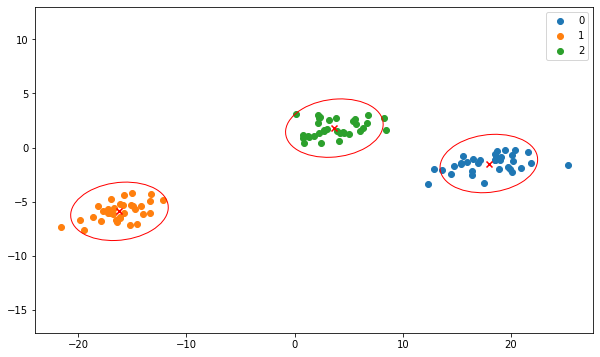

In [5]:
X, y, transformation = generate_dataset(N = 100)
_ = plot_elipses(X, y , transformation)

<div class="qst">

* Completa la clase `GMM` satisfaciendo los requisitos indicados anteriormente.

</div>

Antes de saltar a la implementación, discutamos algunos detalles explicados anteriormente de cara a la misma.

#### Paso E

En el **paso E**, estimaremos $N \times K$ valores de la siguiente forma:

$$
q_i(z_k=1) = \frac{p(z_k=1)p(x_i|z_k=1)}{\sum_{k=1}^K p(z_k=1)p(x_i|z_k=1)}
= \frac{\pi_k \cdot \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)}{\sum_{k=1}^K \pi_k \cdot \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)}
$$

Basta con evaluar la normal multivariante con el vector de medias y matriz de covarianzas adecuadas utilizando la función de `scipy` `multivariate_normal` para obtener los valores de la matriz $Q$.

#### Paso M

En el **paso M** lo que debemos hacer es estimar los parámetros del modelo a partir de los datos como se indica a continuación:

$$ \pi_k = \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) $$

$$
\begin{align*}
\mathbf{\mu}_k & = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i \\
& = \frac{1}{\frac{1}{N}\sum_{i=1}^N q_i(z_k=1)} \frac{1}{N}\sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i \\
& = \frac{1}{\pi_k} \frac{1}{N}\sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i \\
\end{align*}
$$

Como $q_i(z_k=1)$ es la columna $k-$ésima de la matriz $Q$ calculada en el paso E, basta con multiplicar la matriz $X$ (fila a fila) por la columna $k$ de la matriz $Q$ elemento a elemento y calcular la media. Finalmente, dividimos por el valor $\pi_k$ para obtener $\mu_k$.

Para las estimaciones de las covarianzas seguimos un proceso análogo:

$$
\begin{align*}
\Sigma_k & = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T \\
& = \frac{1}{\frac{1}{N}\sum_{i=1}^N q_i(z_k=1)} \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T \\
& = \frac{1}{\pi_k} \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T \\
\end{align*}
$$

#### Inestabilidades numéricas

De cara a reducir las inestabilidades númericas (matrices singulares o no semidefinidas positivas, o dividir por cero al normalizar la matriz $Q$) hemos tomado las siguientes medidas:

- Cuando inicializamos la matriz de covarianzas, o cuando la estimamos en cada iteración durante el paso M, sumaremos a la diagonal de la matriz calculado un valor muy pequeño (controlado por el parámetro `reg_value`, por defecto $10^{-10}$). Esto evitará que la matriz obtenida sea singular y no podamos invertirla al intentar evaluar la normal multivariante.

- Cuando calculamos la matriz $Q$, sumamos un valor muy pequeño (controlado por el mismo parámetro) a todos los valores de la matriz. Esto permitirá que al normalizar dicha matriz dividiendo cada fila por su suma, nos alejemos de dividir por un valor nulo.

#### Inicialización

De cara a inicializar los valores de `priors`, `means` y `covs`, hemos optado por dos métodos distintos controlados por el parámetro `init_method`. Inicialmente implementamos únicamente la primera, pero debido a su rapidísima convergencia pensamos que el modelo estaba mal implementado. Es por ello que añadimos una segunda alternativa:

- Si `init_method = 'kmeans'`, se utiliza el algoritmo de *K-means* para asignar unas etiquetas iniciales a cada punto.
- Si `init_method = 'random'`, la etiqueta de cada punto se inicializa aleatoriamente a una de las posibles clases con igual probabilidad.

A partir de las etiquetas asignadas se estiman los valores de `priors`, `means` y `covs` iniciales por máxima verosimilitud.

#### Cambios en las funciones iniciales

Caben destacar un par de detalles cambiados en las funciones proporcionadas para esta práctica.

- En la generación de los datos se ha fijado la semilla (tanto para `make_blobs` como la semilla de *numpy*) para que todos los experimentos sean completamente reproducibles. También podemos fijar la semilla utilizada por el modelo. En ambos casos controlamos dicha semilla mediante el parámetro `random_state`.

- De cara a pintar las elipses de las covarianzas, hemos comprobado empíricamente que la variable `transformation` proporcionada por la función `generate_dataset` es la matriz raíz cuadrada de la covarianza de los datos. Es por ello que para compararla con las estimaciones de las covarianzas obtenidas pintaremos utilizaremos el cuadrado de dicha matriz.

In [6]:
class GMM:
    """ 
        Sugerencia para la organización del código
    """
    
    def __init__(self, K=3, n_iterations=100, random_state=1234, reg_value=1e-10, init_method='kmeans'):
        self.K = K
        self.n_iterations = n_iterations
        self.random_state = random_state
        self.init_method = init_method
        self.log_likelihoods = []
        
        # Value added to the diagonal of the covariance matrices
        # to avoid singular matrix due to numerical errors.
        self._regularization_val = reg_value
        self._regularization_matrix = reg_value * np.identity(X.shape[1])
    
    def _initialize(self, X):
        if self.init_method == 'kmeans':
            # Apply k-means for a initial prediction of the clusters
            y_pred = KMeans(n_clusters=self.K, random_state=self.random_state).fit_predict(X)
        elif self.init_method == 'random':
            # Randomly assign labels to elements
            np.random.seed(self.random_state)
            y_pred = np.random.randint(self.K, size=X.shape[0])
        else:
            raise ValueError('init_method must be either random or kmeans.')
        
        # Predict initial quantities using the obtained labels
        labels = np.unique(y_pred)
        pi_prior = np.array([ np.sum(y_pred == i) for i in labels ]) / len(y_pred)
        means = np.array([ np.mean(X[y_pred == i], axis=0) for i in labels ])
        
        # Add a small quantity to the covariance matrices' diagonals
        # so they are not singular
        covs = np.array([
            np.cov(X[y_pred == i].T) + self._regularization_matrix
            for i in labels
        ])
        
        return pi_prior, means, covs

    def _e_step(self, X, priors, means, covs):

        # Initialize multivariate normal distributions
        distributions = [
            multivariate_normal(mean=mean, cov=cov)
            for mean, cov in zip(means, covs)
        ]
        
        # Compute the numerator of the Q matrix
        # Add a small regularization value to avoid numerical errors
        Q = np.array([ mvn.pdf(X) for mvn in distributions ]).T * priors + self._regularization_val
        
        # Normalize Q matrix, by dividing each row by the sum of its values.
        Q = Q / np.sum(Q, axis=1).reshape(-1, 1)
        return Q
    
    def _m_step(self, X, Q):
        # Estimate pi
        priors = np.mean(Q, axis=0)
        
        # Estimate means
        means = [
            np.mean(X * Q[:, k].reshape(-1, 1), axis=0) / pi_k
            for k, pi_k  in enumerate(priors)
        ]
        
        # Estimate covariances
        covs = [
            np.mean([
                Q[i, k] * np.matmul((x_i - mean_k).reshape(-1,1), (x_i - mean_k).reshape(1,-1))
                for i, x_i in enumerate(X)
            ], axis = 0) / pi_k
            + self._regularization_matrix
            for k, (pi_k, mean_k)  in enumerate(zip(priors, means))
        ]
        
        return priors, means, covs
        
    def _compute_log_likelihood(self, X, priors, means, covs):
        # Initialize multivariate normal distributions
        distributions = [
            multivariate_normal(mean=mean, cov=cov)
            for mean, cov in zip(means, covs)
        ]
        
        return np.sum([
            np.log(np.sum([
                pi_k * mvn.pdf(x_i)
                for pi_k, mvn in zip(priors, distributions)
            ]))
            for x_i in X
        ])
        
    def fit(self, X):
        # Parameter initialization
        priors, means, covs = self._initialize(X)
        
        # Initialize the log-likelihoog vector
        self.log_likelihoods = [
            self._compute_log_likelihood(X, priors, means, covs)
        ]
        
        for i in range(self.n_iterations):
            # Step E
            Q = self._e_step(X, priors, means, covs)
            
            # Step M
            priors, means, covs = self._m_step(X, Q)
            
            # Compute and save log-likelihood
            self.log_likelihoods.append(
                self._compute_log_likelihood(X, priors, means, covs)
            )
        
        return priors, means, covs

<div class="qst">

* Se deben **visualizar** los resultados obtenidos. Al menos se deben mostrar las covarianzas y medias finales estimadas (usando `make_ellipse`) y cómo ha evolucionado la log-verosimilitud de los datos.

</div>

En primer lugar ajustamos un modelo GMM a nuestros datos mediante ambos métodos de inicialización, tanto aleatoria como mediante kmeans.

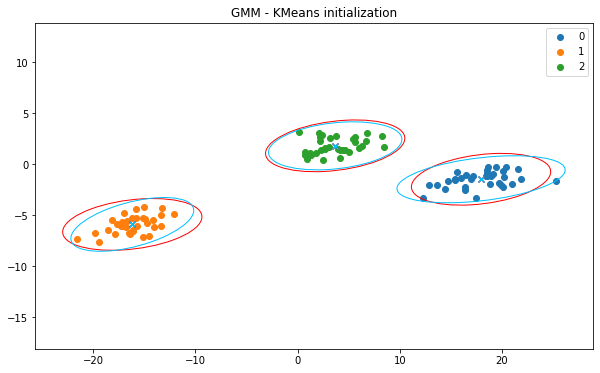

In [7]:
gmm = GMM(n_iterations=100, reg_value=1e-10, init_method='kmeans')
priors, means, covs = gmm.fit(X)
plot_estimations(X, y, transformation, means, covs, 'GMM - KMeans initialization')

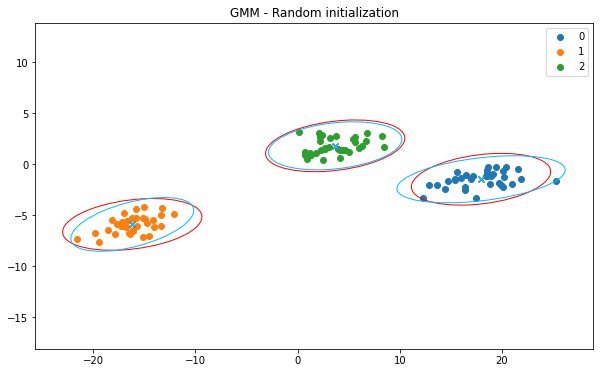

In [8]:
gmm_random = GMM(n_iterations=100, reg_value=1e-10, init_method='random')
priors_random, means_random, covs_random = gmm_random.fit(X)
plot_estimations(X, y, transformation, means_random, covs_random, 'GMM - Random initialization')

En las figuras anteriores las elipses rojas representan las covarianzas de los datos originales mientras que las azules, las estimadas. En primer lugar, las medias son ajustadas a la perfección en ambos casos (ni si quiera podemos apreciar las `x`'s rojas que marcan las medias reales porque las azules están justo encima). Además, los priors encajan también en ambos casos:

In [9]:
print('Priors kmeans: ', priors)
print('Priors random: ', priors_random)

Priors kmeans:  [0.33       0.33999999 0.33      ]
Priors random:  [0.33       0.33       0.33999999]


Sin embargo, las covarianzas no convergen al valor real en ninguno de los dos casos, aunque si se ajustan visualmente a los datos. Finalmente, no podemos encontrar ninguna diferencian visual entre ambos ajustes.

A continuación mostramos la variación de la log-verosimilituddurante la convergencia del algoritmo.

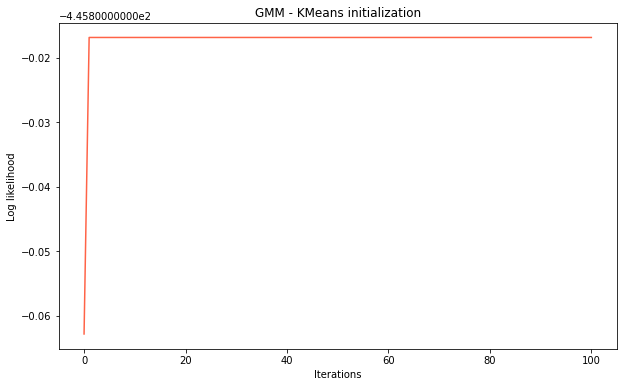

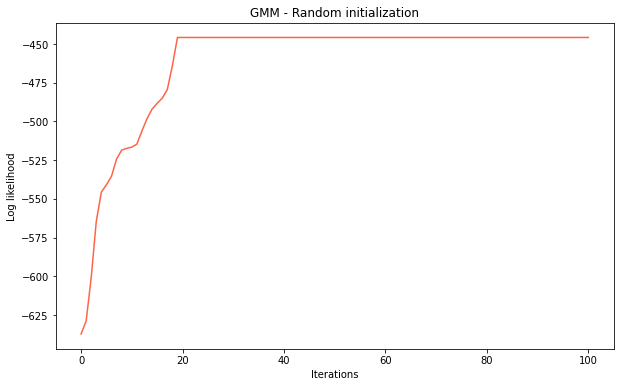

In [10]:
def plot_log_likelihood(gmm, title=None):
    plt.plot(np.arange(gmm.n_iterations + 1), gmm.log_likelihoods, color='tomato')
    plt.xlabel('Iterations')
    plt.ylabel('Log likelihood')
    if title is not None:
        plt.title(title)
    plt.show()
        
plot_log_likelihood(gmm, title='GMM - KMeans initialization')
plot_log_likelihood(gmm_random, title='GMM - Random initialization')

Vemos como la convergencia del modelo inicializado con *K-means* es prácticamente instantánea (en una única iteración hemos obtenido un valor muy cercano al óptimo). Por otro lado, el modelo con inicialización aleatoria necesita alrededor de 20 iteraciones para converger.

Adicionalmente vemos como las gráficas son crecientes. Esto encaja con nuestro estudio del algorimto EM, pues en cada iteración obtendremos una mayor verosimilitud y, por tanto, log-verosimilitud, pues el logarítmico es una función estrictamente cóncava.

Por último, al observar estas gráficas podemos darnos cuenta de que una buena condición de parada prematura para el algoritmo EM sería parar cuando la variación de log-verosimilitud sea muy pequeña.

#### Preguntas adicionales

Los experimentos realizados con anterioridad presentan varias preguntas que no pudimos responder. Intentaremos responder a ellas a continuación.

En primer lugar, en el último apartado vimos como la convergencia del modelo con inicialización *K-means* es asombrosamente rápida. Visualizamos a continuación las predicciones **iniciales** obtenidas por el algoritmo de *K-means* y máxima verosimilitud sin aplicar el algoritmo EM:

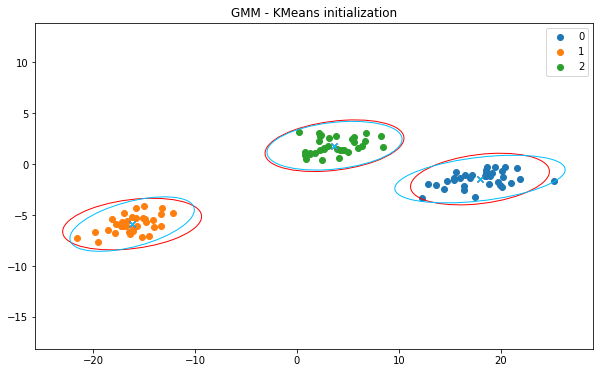

In [11]:
gmm = GMM(n_iterations=100, reg_value=1e-10, init_method='kmeans')
priors, means, covs = gmm._initialize(X)
plot_estimations(X, y, transformation, means, covs, 'GMM - KMeans initialization')

Como podemos apreciar, las estimaciones iniciales son especialmente buenas. Es por ello que el modelo converge tan rápida: nuestra inicialización es realmente cercana al resultado final.

La segunda pregunta a la que daremos respuesta es por qué las covarianzas no consiguen converger a las reales. Para ello realizamos un experimento adicional aumentando el número de datos significativamente:

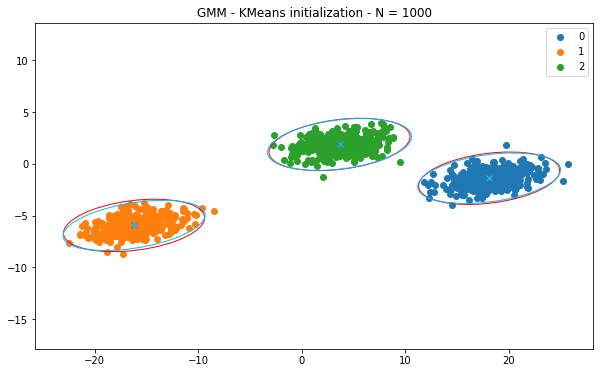

In [12]:
N = 1000
X, y, transformation = generate_dataset(N=N)

gmm = GMM(n_iterations=100, reg_value=1e-10, init_method='kmeans')
priors, means, covs = gmm.fit(X)
plot_estimations(X, y, transformation, means, covs, 'GMM - KMeans initialization - N = {}'.format(N))

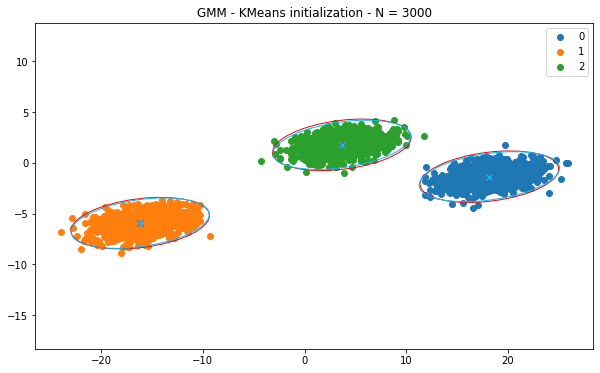

In [13]:
N = 3000
X, y, transformation = generate_dataset(N=N)

gmm = GMM(n_iterations=100, reg_value=1e-10, init_method='kmeans')
priors, means, covs = gmm.fit(X)
plot_estimations(X, y, transformation, means, covs, 'GMM - KMeans initialization - N = {}'.format(N))

La razón por la que las estimaciones de la convarianza no eran tan precisas se debe a que los datos no eran suficientes para estimar dicha matriz de covarianzas correctamente. Como podemos apreciar en las gráficas anteriores, al aumentar el número de puntos en cada clusters aproximamos con mayor precisión las covarianzas objetivo. Cabe destacar que las estimaciones obtenidas en los experimentos anteriores con menos puntos son las que maximizan la verosimilitud para dichos puntos.

Finalmente, para estudiar cómo de bien generaliza el modelo, realicemos el mismo experimento con un mayor número de clusters. Para ello utilizaremos 200 puntos por cluster para una mejorar ligeramente la estimación de las covarianzas y un total de 10 clusters.

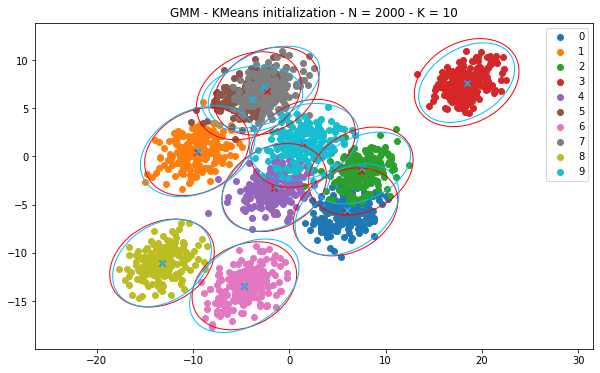

In [14]:
N = 2000
K = 10
X, y, transformation = generate_dataset(N=N, K=K, random_state=123)

gmm = GMM(n_iterations=100, reg_value=1e-10, K=K, init_method='kmeans')
priors, means, covs = gmm.fit(X)
plot_estimations(X, y, transformation, means, covs, 'GMM - KMeans initialization - N = {} - K = {}'.format(N, K))

Como podemos apreciar, para aquellos clusters separados del resto ajustamos mejor tanto la media como la matriz de covarianzas. Cuando más se acercan los clusters, siendo el caso límite los clusters 5 y 7 con un alto solapamiento, más complicado es ajustar estas dos cantidades.

In [15]:
priors

array([0.09451512, 0.10003049, 0.10000102, 0.11302409, 0.10015975,
       0.10339607, 0.08539627, 0.09962595, 0.10654179, 0.09730944])

Vemos como los priors se ajustan relativamente bien a la realidad, siendo el valor objetivo `0.1` para cada posición. Finalmente observemos la convergencia obtenida:

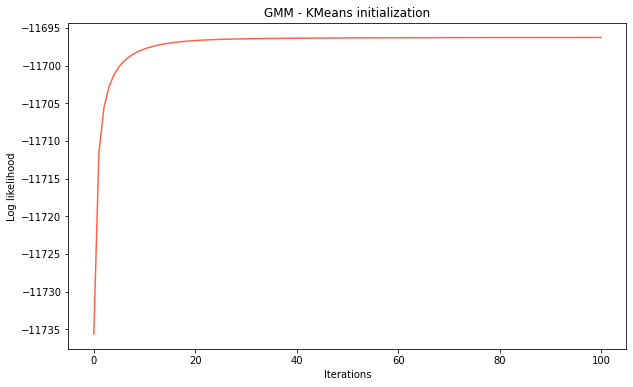

In [16]:
plot_log_likelihood(gmm, title='GMM - KMeans initialization')

Vemos como en este caso más complejo, la convergencia utilizando la inicialización por *K-means* no es instantánea. A pesar de ello es relativamente rápida: en apenas 10 iteraciones estamos muy cerca del valor óptimo y en con 20 prácticamente lo hemos alcanzado. Esto revela que la implementación de la condición de parada a partir de la verosimilitud es necesaria para ejemplos complejos en una implementación más general de este algoritmo.